# Multiple Type Experiment

In [1]:
import warnings;
warnings.filterwarnings('ignore');

from time import sleep
from tqdm.auto import tqdm

import sys
import importlib
import numpy as np
import nbformat
# import plotly.express
# import plotly.express as px
import pandas as pd
import cvxpy as cp
import scipy.optimize as optimization
import matplotlib.pyplot as plt
import seaborn as sns

from solvers import generate_cvxpy_solve, verify_fairness, get_utility, offline_opt, fixed_threshold, hope_online, hope_full, hope_guardrail
from radar_plot import *

In [2]:
#np.random.choice(size=5, a=[1.,2.], p=[1/2, 1/2])
1+np.random.poisson(size=5,lam = 1.5)

array([3, 3, 2, 2, 1])

In [3]:
data = []
num_types = 5
num_resources = 3
weights = np.asarray([[1, 2, 3], [1, 3, 2], [4, 1, 5], [1, 2, .5], [3, 7, 5]])
sum_of_rows = weights.sum(axis=1)
weights = weights / sum_of_rows[:, np.newaxis]

algo_list = {'Fixed Threshold': fixed_threshold,
             'Hope Guardrail $L_T = 1/2$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/2),
             'Hope Guardrail $L_T = 1/3$': lambda a,b,c,d,e,f: hope_guardrail(a,b,c,d,e,f,1/3),
             'Hope Online': hope_online,
             'Hope Full': hope_full}
             

num_algo = len(algo_list)

num_iterations = 50
# num_iterations = 20

act_mean = np.asarray([1.5, 2.5, 3.5, 4.5, 5.5])
mean_size = act_mean
stdev_size = mean_size

utility = 'leontief'

In [4]:

num_groups = np.logspace(2, 10, base=1.5, num=30).astype(int)

# num_groups = np.logspace(2, 5, base=1.5, num=5).astype(int)


for n in tqdm(num_groups):
    n = int(n) + 5
    print('Num Locations: ' + str(n))
    # pected_size = mean_size
#     budget = np.asarray([np.sum(act_mean)*n, np.sum(act_mean)*n, np.sum(act_mean)*n])
    budget = np.asarray([np.dot(act_mean, weights[:,0])*n - np.sqrt(n), np.dot(act_mean, weights[:,1])*n - np.sqrt(n), np.dot(act_mean, weights[:,2])*n - np.sqrt(n)])
    
    
    mean = np.array([mean_size,]*n)
    stdev = mean
    
    for i in range(num_iterations):
        # size = np.random.choice(size=(n, num_types), a=[1.,2.], p=[1/2, 1/2])
        # size = 1+np.maximum(0, np.random.normal(size=(n, num_types), loc = mean_size-1, scale = .2))
        size = 1 + np.random.poisson(size = (n, num_types), lam = mean_size - 1)
        # print('Size: ' + str(size))
        total_num_types = np.sum(size, axis=0)
        prob, solver = generate_cvxpy_solve(num_types, num_resources, utility)

        
        opt = offline_opt(budget, size, weights, solver)
        
        index = 0
        for algo in algo_list:
            
        
            sol, waste = algo_list[algo](budget, size, mean, stdev, weights, solver)
            
            waste, envy, proportionality, c_envy = verify_fairness(weights, sol, np.asarray(size), np.asarray(budget), utility, opt)
            
            
#             alloc_diff[index, i, :, :, :] = opt - sol
            data_dict = {'NumGroups': n, 'Algorithm': algo, 'Norm': 'Hindsight_Envy', 'Value': envy}
            data.append(data_dict)
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Proportionality', 'Value': proportionality}
            data.append(data_dict)
            
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Waste', 'Value': waste}
            data.append(data_dict)
            
            data_dict = {'NumGroups': n, 'Algorithm':algo, 'Norm': 'Counterfactual_Envy', 'Value': c_envy}
            data.append(data_dict)
            

  0%|          | 0/30 [00:00<?, ?it/s]

Num Locations: 7
Num Locations: 7
Num Locations: 7
Num Locations: 8
Num Locations: 8
Num Locations: 8
Num Locations: 9
Num Locations: 9
Num Locations: 10
Num Locations: 11
Num Locations: 11
Num Locations: 12
Num Locations: 13
Num Locations: 14
Num Locations: 15
Num Locations: 17
Num Locations: 18
Num Locations: 20
Num Locations: 21
Num Locations: 23
Num Locations: 26
Num Locations: 28
Num Locations: 31
Num Locations: 34
Num Locations: 37
Num Locations: 41
Num Locations: 46
Num Locations: 51
Num Locations: 56
Num Locations: 62


In [5]:
df = pd.DataFrame.from_records(data)
df.to_csv('./data_leontief/multi_poisson.csv', index=False)
df = pd.read_csv('./data_leontief/multi_poisson.csv')

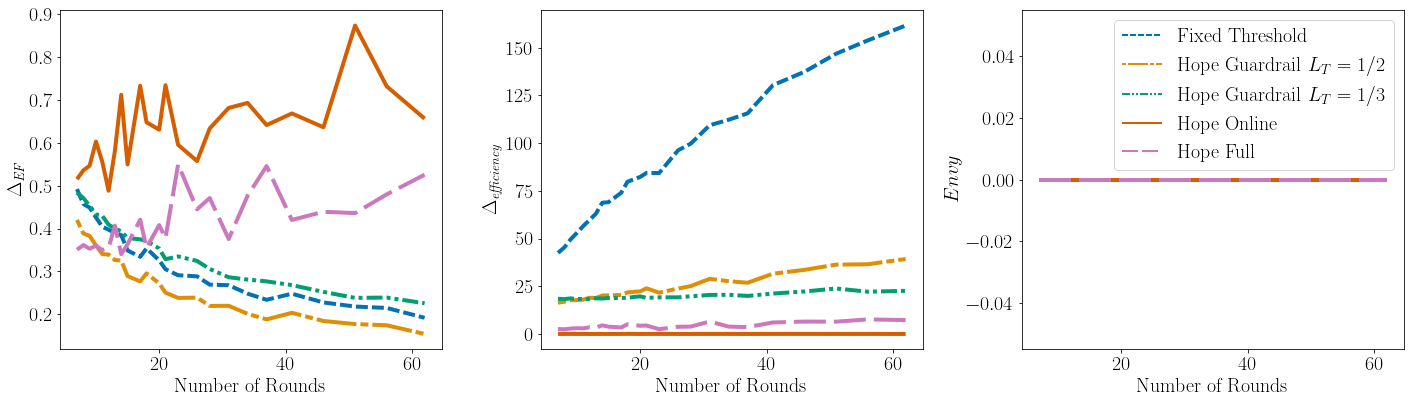

In [6]:

df.columns
df = df.assign(Algorithm = lambda df: df.Algorithm.replace({'fixed_threshold': 'Fixed Threshold', 'hope_guardrail_13': 'Guarded Hope $L_T = T^{-1/3}$', 'hope_guardrail_12': 'Guarded Hope $L_T = T^{-1/2}$'}))



plt.style.use('PaperDoubleFig.mplstyle.txt')
# Make some style choices for plotting 
# colorWheel =['#2bd1e5',
#             '#281bf5',
#              '#db1bf5',
#              '#F5CD1B',
#             '#FF5733','#9cf51b',]
dashesStyles = [[3,1],
            [2,1,10,1],
            [4, 1, 1, 1, 1, 1],[1000,1],[8,2]]


#filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
#plt.figure(figsize=(20,10))
#plt.title('Simple Distribution L1')
#sns.lineplot(x='NumGroups', y='value', hue='variable', data=df[df.Norm == 'L1'])

filled_markers = ('o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X')
dash_styles = ["",
               (4, 1.5),
               (1, 1),
               (3, 1, 1.5, 1),
               (5, 1, 1, 1),
               (5, 1, 2, 1, 2, 1),
               (2, 2, 3, 1.5),
               (1, 2.5, 3, 1.2)]

# fig = plt.figure(figsize=(20,6))
plt.rc('text', usetex=True)



fg, axs = plt.subplots(1,3, sharex='all', figsize=(20,6))
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)],
                     data=df[df.Norm == 'Counterfactual_Envy'], ax = axs[0], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)
sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Waste'], ax = axs[1], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)

sns.lineplot(x='NumGroups', y='Value', hue='Algorithm', style = 'Algorithm', dashes = dashesStyles[0:len(algo_list)], 
             data=df[df.Norm == 'Hindsight_Envy'], ax = axs[2], linewidth=4, palette = sns.color_palette("colorblind", len(algo_list)),
            ci = None)



axs[0].get_legend().remove()
axs[0].set_ylabel('$\Delta_{\it EF}$')
axs[0].set_xlabel('Number of Rounds')

axs[1].set_ylabel('$\Delta_{\it efficiency}$')
axs[1].set_xlabel('Number of Rounds')
axs[1].get_legend().remove()

axs[2].get_legend().remove()
axs[2].set_ylabel(r'$Envy$')
axs[2].set_xlabel('Number of Rounds')


axs[2].legend(ncol = 1, loc= 'upper right')




plt.show()
fg.savefig('./figures/synthetic_multi.pdf', bbox_inches = 'tight',pad_inches = 0.01, dpi=900)